In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# import evaluation
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import os
import gc
import shutil 

if not os.path.exists('./TextModel'):
    os.makedirs('./TextModel')
    
batch_size = 32
epochs = 50
embed_size = 512 #according to USE
threshold = 0.5

#Universal Sentence Encoder
tf.compat.v1.disable_eager_execution()

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed"
embed = hub.Module(module_url)

In [2]:
#pip install -r requirements.txt
'''
requires the same folder:
- script evaluation
-folder 'ref' with truth.txt
'''

#path
# csv_path_test = './test.csv'

# csv_path_train = './train.csv'
csv_path_train = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/training.csv'


In [6]:
entire_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'], sep='\t')

In [27]:
# splitting the data into train and test set
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(entire_df, stratify=entire_df['misogynous'], test_size=0.5)

In [42]:
txt_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'shaming', 'stereotype', 'objectification', 'violence'], sep='\t')
txt_df.to_csv('/content/drive/Shareddrives/team_MAMI/MAMI/Baselines/truth.txt', sep='\t', index=False)

In [26]:

#_______________________________Load Training Data_______________________________
# train_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'], sep='\t')
# train_df = X_train

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(train_df, 10)

train_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()
      
train_df['USE'] = text_embeddings

#division and processing of data as input to the model
X_train = train_df[['file_name', 'USE']]
y_train = train_df['misogynous']

#text
tmp = []
for value in X_train['USE']:
    tmp.append([value])  
tX_train = np.array(tmp)

#misogynous label
tmp = []
for value in y_train:
    tmp.append([value])  
y_train = np.array(tmp)

#clear memory
del train_df
del dfs
del text_embedding
del text_embeddings

gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 512)]          0         
                                                                 
 dense (Dense)               (None, 1, 1)              513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


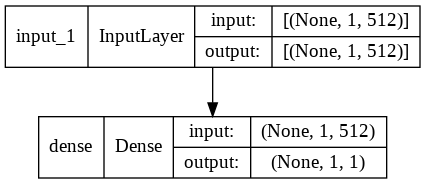

In [28]:

#_______________________________TEXT MODEL_______________________________
input_text = layers.Input(shape=(1, embed_size))
l = layers.Dense(1, activation='sigmoid')(input_text)
model = Model(inputs=[input_text], outputs=l)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(tX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= epochs,
                    batch_size=batch_size,
                    verbose=0)
                    
model.save('./TextModel/model_text.h5')
tf.keras.utils.plot_model(model, "./TextModel/model_text.png", show_shapes=True)


In [29]:

#_______________________________Load Test Data_______________________________
#clear memory
del X_train
del y_train
del tX_train

gc.collect()

# test_df = pd.read_csv(csv_path_test, sep='\t')
# test_df = X_train

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(test_df, 10)

test_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()

test_df['USE'] = text_embeddings

#division and processing of data as input to the model
#Text
tmp = []
for value in test_df['USE']:
    tmp.append([value])  
tX_test = np.array(tmp)

#clear memory
del dfs
del text_embedding
del text_embeddings

gc.collect()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0

In [30]:
#_______________________________PREDICTION_______________________________
predictions = model.predict(tX_test, batch_size=batch_size)
predictions = predictions.reshape(predictions.shape[0])
pred = predictions > threshold
pred = list(map(int, pred)) #true/false to 1/0

predictions_db = pd.DataFrame(data=test_df['file_name'])
predictions_db['misogynist'] = pred



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [44]:
import sys
sys.path.append('/content/drive/Shareddrives/team_MAMI/MAMI/Baselines/')

In [52]:
#_______________________________EVALUATION_______________________________

import evaluation

if not os.path.exists('./res'):
    os.makedirs('./res')
    
predictions_db.to_csv('./res/answer.txt', index=False, sep='\t', header=False)
# evaluation.main(['','./', './TextModel/'])
# #move res folder to TextModel folder
# shutil.move('./res/', './TextModel/res/')




0.681282479668547

In [57]:
from sklearn.metrics import f1_score

f1_score(test_df['misogynous'], predictions_db['misogynist'], average='micro')

0.6912